# Data Augmentation
This notebook performs data augmentation on the dataset by creating an augmented copy of each image in the original dataset. Original dataset images are taken from the ```dataset``` folder, while original and augmented images are saved to the ```dataset-augmented``` folder.

### Import Libraries

In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from io import StringIO
from matplotlib import pyplot as plt
import shutil
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import make_grid, save_image
from torch.utils.data import Dataset, DataLoader

C:\Users\Irish\anaconda3\envs\conv_env\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] The specified procedure could not be found
  warn(f"Failed to load image Python extension: {e}")


### Define Variables & Helper Functions

In [2]:
# Folders for input (original images) and output (original + augmented images)
in_folder = r"dataset/"
out_folder = r"dataset-augmented/"

In [3]:
# Set seed for PyTorch random number generation to create reproducible results
torch.manual_seed(5)

In [4]:
# Convert PIL Image to tensor
to_tensor = transforms.Compose([
    # Convert PIL Image to tensor and scale to [0, 1] through max normalization
    # (i.e. for every pixel in image, new_pixel_value = pixel/255)
    transforms.ToTensor()
])

translation_matrix = torch.tensor([[0, 1, 0], [0, 0, 1], [1, 0, 0]])

# Transformations to apply to inputs, where one is randomly chosen and applied per image
augmentations = transforms.RandomChoice([
    # Rotate by a random amount within -3 to -1 degrees
    transforms.RandomRotation(degrees=(-3, -1), fill=255), 
    
    # Rotate by a random amount within 1 to 3 degrees
    transforms.RandomRotation(degrees=(1, 3), fill=255), 
    
    # Translate horizontally by a random percentage between -15% and 15% and
    # vertically by a random percentage between -15% and 15%
    transforms.RandomAffine(degrees=0, translate=(0.15, 0.15), fill=255), 
    
    # Horizontally flips the image
    transforms.RandomHorizontalFlip(p=1)
])

In [5]:
# Helper function to get ground truth class of an image
def get_img_labels(img_dir):
    labels = ''
    
    for filename in os.listdir(img_dir):
        # If image has no metastasis
        if (filename[5] == '0'):
            labels += filename + ",0\n"
            
        # If image has metastasis
        else:
            labels += filename + ",1\n"
        
    return labels

### Augment Data

In [6]:
# Image dataset
class AugmentedDataset(Dataset):
    def __init__(self, img_dir, to_tensor, augment):
        self.img_dir = img_dir
        self.img_labels = pd.read_csv(StringIO(get_img_labels(img_dir)), sep=",", header=None)
        self.to_tensor = to_tensor
        self.augment = augmentations

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        # Generate image filepath
        filename = self.img_labels.iloc[idx, 0]
        img_path = self.img_dir + "/" + filename
        
        # Augment image
        image = Image.open(img_path).convert("RGB")
        image = self.to_tensor(image)
        image = self.augment(image)
        
        # Determine ground truth class (metastasis or no metastasis)
        label = self.img_labels.iloc[idx, 1]
        return image, label, filename

In [7]:
# Dataset and dataloader for images
data = AugmentedDataset(img_dir=in_folder, to_tensor=to_tensor, augment=augmentations)
loader = DataLoader(data, batch_size=10, shuffle=True)

### Show Sample of Augmented Data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Classes: 1 0 1 1 0 1 0 0 0 0
Original files:
0718-1-A.tif
0083-0-P.tif
0408-1-A.tif
0422-1-A.tif
0375-0-P.tif
0994-1-A.tif
0594-0-A.tif
1031-0-P.tif
0091-0-P.tif
0935-0-A.tif


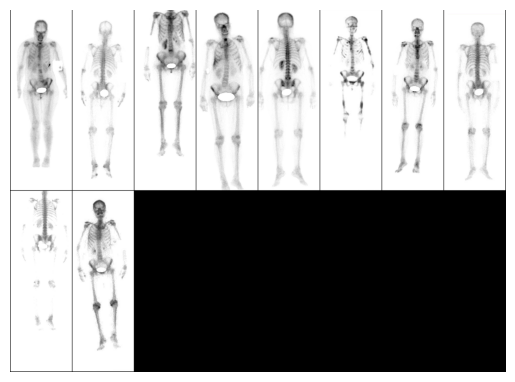

In [8]:
# Show random augmented images and their ground truth classes
dataiter = iter(loader)
images, labels, filenames = next(dataiter)

plt.axis('off')
plt.imshow(make_grid(images).permute(1,2,0))
print("Classes: " + ' '.join(f'{labels[j]}' for j in range(len(labels))))
print("Original files:\n" + '\n'.join(f'{filenames[j]}' for j in range(len(filenames))))

### Save Augmented Images to Output Folder

In [9]:
# Copy original images to output folder
for filename in os.listdir(in_folder):
    in_file = os.path.join(in_folder, filename)
    shutil.copy(in_file, out_folder)

In [10]:
# Get index of last original image
last_filename = os.listdir(in_folder)[-1]
img_index = int(last_filename[0:4])

In [11]:
# Delete all previous copies of augmented images in folder (if any)
for filename in os.listdir(out_folder):
    if (int(filename[0:4]) > img_index):
        os.remove(os.path.join(out_folder, filename))

In [12]:
for batch_index, batch_data in enumerate(loader):
    # Get the images, labels, and filenames in the current batch
    images, labels, orig_filenames = batch_data
    
    for i in range(len(images)):
        # Create filename for augmented image
        img_index += 1
        new_filename = str(img_index) + orig_filenames[i][4:]
        img_path = out_folder + "/" + new_filename
        
        # Save augmented image
        save_image(images[i], img_path)
        print(f"Saved augmented copy of {orig_filenames[i]} as {new_filename} in {out_folder}")

Saved augmented copy of 0447-0-P.tif as 1226-0-P.tif in dataset-augmented/
Saved augmented copy of 0952-0-A.tif as 1227-0-A.tif in dataset-augmented/
Saved augmented copy of 1185-1-P.tif as 1228-1-P.tif in dataset-augmented/
Saved augmented copy of 0130-0-A.tif as 1229-0-A.tif in dataset-augmented/
Saved augmented copy of 0461-0-P.tif as 1230-0-P.tif in dataset-augmented/
Saved augmented copy of 0962-1-A.tif as 1231-1-A.tif in dataset-augmented/
Saved augmented copy of 0615-1-A.tif as 1232-1-A.tif in dataset-augmented/
Saved augmented copy of 1135-0-P.tif as 1233-0-P.tif in dataset-augmented/
Saved augmented copy of 0649-1-P.tif as 1234-1-P.tif in dataset-augmented/
Saved augmented copy of 0642-0-A.tif as 1235-0-A.tif in dataset-augmented/
Saved augmented copy of 0060-1-A.tif as 1236-1-A.tif in dataset-augmented/
Saved augmented copy of 0025-0-P.tif as 1237-0-P.tif in dataset-augmented/
Saved augmented copy of 0774-0-A.tif as 1238-0-A.tif in dataset-augmented/
Saved augmented copy of 0

Saved augmented copy of 0116-1-A.tif as 1336-1-A.tif in dataset-augmented/
Saved augmented copy of 1010-0-P.tif as 1337-0-P.tif in dataset-augmented/
Saved augmented copy of 0100-1-A.tif as 1338-1-A.tif in dataset-augmented/
Saved augmented copy of 0011-0-P.tif as 1339-0-P.tif in dataset-augmented/
Saved augmented copy of 0784-0-A.tif as 1340-0-A.tif in dataset-augmented/
Saved augmented copy of 0336-0-A.tif as 1341-0-A.tif in dataset-augmented/
Saved augmented copy of 0933-0-A.tif as 1342-0-A.tif in dataset-augmented/
Saved augmented copy of 0822-0-A.tif as 1343-0-A.tif in dataset-augmented/
Saved augmented copy of 0510-0-A.tif as 1344-0-A.tif in dataset-augmented/
Saved augmented copy of 0018-0-P.tif as 1345-0-P.tif in dataset-augmented/
Saved augmented copy of 0724-0-P.tif as 1346-0-P.tif in dataset-augmented/
Saved augmented copy of 0298-0-P.tif as 1347-0-P.tif in dataset-augmented/
Saved augmented copy of 0519-0-P.tif as 1348-0-P.tif in dataset-augmented/
Saved augmented copy of 0

Saved augmented copy of 0367-0-P.tif as 1446-0-P.tif in dataset-augmented/
Saved augmented copy of 1178-1-P.tif as 1447-1-P.tif in dataset-augmented/
Saved augmented copy of 0938-0-A.tif as 1448-0-A.tif in dataset-augmented/
Saved augmented copy of 0131-0-P.tif as 1449-0-P.tif in dataset-augmented/
Saved augmented copy of 0864-0-A.tif as 1450-0-A.tif in dataset-augmented/
Saved augmented copy of 1069-0-P.tif as 1451-0-P.tif in dataset-augmented/
Saved augmented copy of 0166-0-A.tif as 1452-0-A.tif in dataset-augmented/
Saved augmented copy of 0931-0-A.tif as 1453-0-A.tif in dataset-augmented/
Saved augmented copy of 1002-1-A.tif as 1454-1-A.tif in dataset-augmented/
Saved augmented copy of 0023-0-P.tif as 1455-0-P.tif in dataset-augmented/
Saved augmented copy of 0091-0-P.tif as 1456-0-P.tif in dataset-augmented/
Saved augmented copy of 0418-0-A.tif as 1457-0-A.tif in dataset-augmented/
Saved augmented copy of 0274-1-A.tif as 1458-1-A.tif in dataset-augmented/
Saved augmented copy of 0

Saved augmented copy of 0742-0-A.tif as 1556-0-A.tif in dataset-augmented/
Saved augmented copy of 0385-0-P.tif as 1557-0-P.tif in dataset-augmented/
Saved augmented copy of 0283-1-A.tif as 1558-1-A.tif in dataset-augmented/
Saved augmented copy of 0949-0-A.tif as 1559-0-A.tif in dataset-augmented/
Saved augmented copy of 0293-1-P.tif as 1560-1-P.tif in dataset-augmented/
Saved augmented copy of 0764-0-A.tif as 1561-0-A.tif in dataset-augmented/
Saved augmented copy of 0953-0-A.tif as 1562-0-A.tif in dataset-augmented/
Saved augmented copy of 0080-0-A.tif as 1563-0-A.tif in dataset-augmented/
Saved augmented copy of 0841-0-A.tif as 1564-0-A.tif in dataset-augmented/
Saved augmented copy of 0481-0-P.tif as 1565-0-P.tif in dataset-augmented/
Saved augmented copy of 0082-0-A.tif as 1566-0-A.tif in dataset-augmented/
Saved augmented copy of 0087-0-P.tif as 1567-0-P.tif in dataset-augmented/
Saved augmented copy of 0644-0-A.tif as 1568-0-A.tif in dataset-augmented/
Saved augmented copy of 0

Saved augmented copy of 0486-0-A.tif as 1670-0-A.tif in dataset-augmented/
Saved augmented copy of 0665-0-P.tif as 1671-0-P.tif in dataset-augmented/
Saved augmented copy of 1018-0-P.tif as 1672-0-P.tif in dataset-augmented/
Saved augmented copy of 0903-0-A.tif as 1673-0-A.tif in dataset-augmented/
Saved augmented copy of 0493-0-P.tif as 1674-0-P.tif in dataset-augmented/
Saved augmented copy of 0306-1-A.tif as 1675-1-A.tif in dataset-augmented/
Saved augmented copy of 0127-0-P.tif as 1676-0-P.tif in dataset-augmented/
Saved augmented copy of 0599-1-P.tif as 1677-1-P.tif in dataset-augmented/
Saved augmented copy of 1041-0-P.tif as 1678-0-P.tif in dataset-augmented/
Saved augmented copy of 1221-1-P.tif as 1679-1-P.tif in dataset-augmented/
Saved augmented copy of 0296-0-P.tif as 1680-0-P.tif in dataset-augmented/
Saved augmented copy of 0701-1-P.tif as 1681-1-P.tif in dataset-augmented/
Saved augmented copy of 0332-0-A.tif as 1682-0-A.tif in dataset-augmented/
Saved augmented copy of 0

Saved augmented copy of 0489-1-A.tif as 1786-1-A.tif in dataset-augmented/
Saved augmented copy of 0270-1-A.tif as 1787-1-A.tif in dataset-augmented/
Saved augmented copy of 1198-1-P.tif as 1788-1-P.tif in dataset-augmented/
Saved augmented copy of 0557-0-P.tif as 1789-0-P.tif in dataset-augmented/
Saved augmented copy of 0217-0-P.tif as 1790-0-P.tif in dataset-augmented/
Saved augmented copy of 0650-0-A.tif as 1791-0-A.tif in dataset-augmented/
Saved augmented copy of 1117-0-P.tif as 1792-0-P.tif in dataset-augmented/
Saved augmented copy of 1172-0-P.tif as 1793-0-P.tif in dataset-augmented/
Saved augmented copy of 0200-0-A.tif as 1794-0-A.tif in dataset-augmented/
Saved augmented copy of 0916-0-A.tif as 1795-0-A.tif in dataset-augmented/
Saved augmented copy of 0041-1-P.tif as 1796-1-P.tif in dataset-augmented/
Saved augmented copy of 1168-0-P.tif as 1797-0-P.tif in dataset-augmented/
Saved augmented copy of 1116-0-P.tif as 1798-0-P.tif in dataset-augmented/
Saved augmented copy of 1

Saved augmented copy of 0059-0-P.tif as 1896-0-P.tif in dataset-augmented/
Saved augmented copy of 0172-0-A.tif as 1897-0-A.tif in dataset-augmented/
Saved augmented copy of 0136-0-A.tif as 1898-0-A.tif in dataset-augmented/
Saved augmented copy of 0008-0-A.tif as 1899-0-A.tif in dataset-augmented/
Saved augmented copy of 0039-0-P.tif as 1900-0-P.tif in dataset-augmented/
Saved augmented copy of 0965-1-A.tif as 1901-1-A.tif in dataset-augmented/
Saved augmented copy of 0307-1-P.tif as 1902-1-P.tif in dataset-augmented/
Saved augmented copy of 0907-0-A.tif as 1903-0-A.tif in dataset-augmented/
Saved augmented copy of 0171-1-P.tif as 1904-1-P.tif in dataset-augmented/
Saved augmented copy of 0101-1-P.tif as 1905-1-P.tif in dataset-augmented/
Saved augmented copy of 0005-1-P.tif as 1906-1-P.tif in dataset-augmented/
Saved augmented copy of 0111-0-P.tif as 1907-0-P.tif in dataset-augmented/
Saved augmented copy of 0561-1-P.tif as 1908-1-P.tif in dataset-augmented/
Saved augmented copy of 0

Saved augmented copy of 0501-1-P.tif as 2007-1-P.tif in dataset-augmented/
Saved augmented copy of 0448-0-P.tif as 2008-0-P.tif in dataset-augmented/
Saved augmented copy of 0723-0-P.tif as 2009-0-P.tif in dataset-augmented/
Saved augmented copy of 0144-0-P.tif as 2010-0-P.tif in dataset-augmented/
Saved augmented copy of 0188-1-A.tif as 2011-1-A.tif in dataset-augmented/
Saved augmented copy of 0585-1-P.tif as 2012-1-P.tif in dataset-augmented/
Saved augmented copy of 0889-0-A.tif as 2013-0-A.tif in dataset-augmented/
Saved augmented copy of 0500-1-A.tif as 2014-1-A.tif in dataset-augmented/
Saved augmented copy of 0064-0-A.tif as 2015-0-A.tif in dataset-augmented/
Saved augmented copy of 1194-1-P.tif as 2016-1-P.tif in dataset-augmented/
Saved augmented copy of 0408-1-A.tif as 2017-1-A.tif in dataset-augmented/
Saved augmented copy of 0363-0-P.tif as 2018-0-P.tif in dataset-augmented/
Saved augmented copy of 0983-1-A.tif as 2019-1-A.tif in dataset-augmented/
Saved augmented copy of 1

Saved augmented copy of 1083-0-P.tif as 2126-0-P.tif in dataset-augmented/
Saved augmented copy of 0097-1-P.tif as 2127-1-P.tif in dataset-augmented/
Saved augmented copy of 1092-0-P.tif as 2128-0-P.tif in dataset-augmented/
Saved augmented copy of 1212-1-P.tif as 2129-1-P.tif in dataset-augmented/
Saved augmented copy of 0268-0-P.tif as 2130-0-P.tif in dataset-augmented/
Saved augmented copy of 1071-0-P.tif as 2131-0-P.tif in dataset-augmented/
Saved augmented copy of 0499-0-P.tif as 2132-0-P.tif in dataset-augmented/
Saved augmented copy of 1000-1-A.tif as 2133-1-A.tif in dataset-augmented/
Saved augmented copy of 0910-0-A.tif as 2134-0-A.tif in dataset-augmented/
Saved augmented copy of 0866-0-A.tif as 2135-0-A.tif in dataset-augmented/
Saved augmented copy of 1112-0-P.tif as 2136-0-P.tif in dataset-augmented/
Saved augmented copy of 0817-0-A.tif as 2137-0-A.tif in dataset-augmented/
Saved augmented copy of 0641-0-P.tif as 2138-0-P.tif in dataset-augmented/
Saved augmented copy of 0

Saved augmented copy of 0468-1-A.tif as 2236-1-A.tif in dataset-augmented/
Saved augmented copy of 0541-1-P.tif as 2237-1-P.tif in dataset-augmented/
Saved augmented copy of 0884-0-A.tif as 2238-0-A.tif in dataset-augmented/
Saved augmented copy of 0304-1-A.tif as 2239-1-A.tif in dataset-augmented/
Saved augmented copy of 0869-0-A.tif as 2240-0-A.tif in dataset-augmented/
Saved augmented copy of 0052-0-P.tif as 2241-0-P.tif in dataset-augmented/
Saved augmented copy of 0617-0-P.tif as 2242-0-P.tif in dataset-augmented/
Saved augmented copy of 0129-1-P.tif as 2243-1-P.tif in dataset-augmented/
Saved augmented copy of 0042-0-A.tif as 2244-0-A.tif in dataset-augmented/
Saved augmented copy of 0926-0-A.tif as 2245-0-A.tif in dataset-augmented/
Saved augmented copy of 0812-0-A.tif as 2246-0-A.tif in dataset-augmented/
Saved augmented copy of 0947-0-A.tif as 2247-0-A.tif in dataset-augmented/
Saved augmented copy of 0902-0-A.tif as 2248-0-A.tif in dataset-augmented/
Saved augmented copy of 0

Saved augmented copy of 0047-1-P.tif as 2346-1-P.tif in dataset-augmented/
Saved augmented copy of 0763-0-P.tif as 2347-0-P.tif in dataset-augmented/
Saved augmented copy of 0357-0-P.tif as 2348-0-P.tif in dataset-augmented/
Saved augmented copy of 0219-1-A.tif as 2349-1-A.tif in dataset-augmented/
Saved augmented copy of 0805-0-A.tif as 2350-0-A.tif in dataset-augmented/
Saved augmented copy of 1144-0-P.tif as 2351-0-P.tif in dataset-augmented/
Saved augmented copy of 0146-0-A.tif as 2352-0-A.tif in dataset-augmented/
Saved augmented copy of 1091-0-P.tif as 2353-0-P.tif in dataset-augmented/
Saved augmented copy of 0329-1-P.tif as 2354-1-P.tif in dataset-augmented/
Saved augmented copy of 0273-1-P.tif as 2355-1-P.tif in dataset-augmented/
Saved augmented copy of 0997-1-A.tif as 2356-1-A.tif in dataset-augmented/
Saved augmented copy of 0340-1-A.tif as 2357-1-A.tif in dataset-augmented/
Saved augmented copy of 0483-0-P.tif as 2358-0-P.tif in dataset-augmented/
Saved augmented copy of 0